# Preprocessing and Modeling

## Install and Import

Most of this code was actually run in multiple Google Colab notebooks, depending on the computational power needed. We used a few packages which are not installed on Colab devices by default.

In [ ]:
!pip install evaluate

!pip install transformers[torch]

!pip install sacrebleu

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import accelerate
import evaluate
import json
import random

## Training Code

For most of our training, we set the maximum generation length, MY_MODEL_MAX_LENGTH to 1400 because that is the length necessary to use most of the training data available.

We first train 9 epochs on our full dataset with this model length, which takes about 20 hours per epoch using 22GB of GPU RAM.

We later train 50 more epochs on a significantly smaller subset of this training data, to try to squeeze some extra performance out of the model, but this extra training does not appear to be effective.

We start by loading the tokenizer and model from Leandojo's ReProver. Although their model's goal is different from ours, since the language is the same, the hope is to leverage transferred learning for deeper layers of the neural network by starting with their model instead of from scratch.

In [ ]:
MY_MODEL_MAX_LENGTH = 1400      # change to 140 to run more epochs
NUM_OF_EPOCHS = 9

tokenizer = AutoTokenizer.from_pretrained("kaiyuy/leandojo-lean4-tacgen-byt5-small", model_max_length=MY_MODEL_MAX_LENGTH)
model = AutoModelForSeq2SeqLM.from_pretrained("kaiyuy/leandojo-lean4-tacgen-byt5-small")

In [ ]:
def data_from_json(json_data):
  list_of_input_output_dicts = []
  for thm in json_data:
    new_dicts = [{key: tac[key] for key in ['state_before', 'expanded_tactic']} for tac in thm['traced_tactics']]
    list_of_input_output_dicts.extend(new_dicts)
  return list_of_input_output_dicts

def tokenized_from_strings(string_list):
  return [tokenizer(x, padding='max_length', truncation=True, return_tensors='pt') for x in string_list]

def dicts_from_in_outs(in_out_list):
  input_strings = [x['state_before'] for x in in_out_list]
  label_strings = [x['expanded_tactic'] for x in in_out_list]
  inputs_tokenized = tokenized_from_strings(input_strings)
  labels_tokenized = tokenized_from_strings(label_strings)
  return [{'input_ids': x['input_ids'][0], 'labels': y['input_ids'][0]} for x,y in zip(inputs_tokenized, labels_tokenized)]

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/mytrain.json", "r") as read_file:
    initial_data = json.load(read_file)
    train_data = dicts_from_in_outs(data_from_json(initial_data))

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/checkpoints",
    overwrite_output_dir=True,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    save_steps=5000,
    num_train_epochs=9,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
)

In [ ]:
trainer.train()

## Evaluation

Having trained our model, we now the compare the performance at each epoch on the validation set.

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/myval_simple.json", "r") as read_file:
    initial_data = json.load(read_file)
    val_data = dicts_from_in_outs(data_from_json(initial_data))

We use the "bleu" and "chr f" metrics, which are standard metrics in sequence-to-sequence model evaluation (traditionally for translating between languages).

In [ ]:
mt_metrics = evaluate.combine(
    ["bleu", "chrf"], force_prefix=True
)

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    predictions = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    references = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    outputs = mt_metrics.compute(predictions=predictions,
                             references=references)

    return outputs

In [ ]:
def evaluate_model(model, data=val_data):
  training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/checkpoints",
    per_device_eval_batch_size=1,
    predict_with_generate=True,
    report_to=None,
    generation_max_length = MY_MODEL_MAX_LENGTH,
    eval_accumulation_steps=20
  )

  trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    eval_dataset=data,
    compute_metrics=compute_metrics,
  )

  eval_output = trainer.evaluate(max_length=MY_MODEL_MAX_LENGTH)
  return eval_output

In [ ]:
models = [AutoModelForSeq2SeqLM.from_pretrained(
            "/content/drive/MyDrive/Colab Notebooks/epoch" + str(epoch) + "model"
            )
          for epoch in range(2,10)]

eval_metrics = []
for model in models:
  this_epoch_metrics = evaluate_model(model, val_data)
  eval_metrics += [this_epoch_metrics]

with open("/content/drive/MyDrive/Colab Notebooks/eval_metrics.json", "w") as fp:
  json.dump(eval_metrics, fp)

In [ ]:
models = [AutoModelForSeq2SeqLM.from_pretrained(
            "/content/drive/MyDrive/Colab Notebooks/checkpoints/checkpoint-" + str(5000*i)
            )
          for i in range(0,6)]

eval_metrics = []
for model in models:
  this_epoch_metrics = evaluate_model(model, val_data)
  eval_metrics += [this_epoch_metrics]

with open("/content/drive/MyDrive/Colab Notebooks/eval_metrics_short.json", "w") as fp:
  json.dump(eval_metrics, fp)

## Analyzing Evaluations

Having run our evaluations on the validation dataset, let's explore the data with some graphs.

In [6]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
with open("eval_metrics.json", "r") as read_file:
    eval_metrics = json.load(read_file)

with open("eval_metrics_short.json", "r") as read_file:
    eval_metrics_short = json.load(read_file)

In [3]:
def extract_data(data, column):
  return pd.Series([entry[column] for entry in data])

In [4]:
columns = ['eval_loss', 'eval_bleu_bleu', 'eval_chr_f_score']

dict_for_df = {col : extract_data(eval_metrics, col) for col in columns}
dict_for_df['epoch'] = [0] + list(range(2,10))
dict_for_df_short = {col : extract_data(eval_metrics_short, col) for col in columns}
dict_for_df_short['step'] = [i*5000 for i in range(6)]

df = pd.DataFrame(dict_for_df).set_index('epoch')
df_short = pd.DataFrame(dict_for_df_short).set_index('step')

Let's first look at the loss over time.

<Axes: xlabel='epoch', ylabel='eval_loss'>

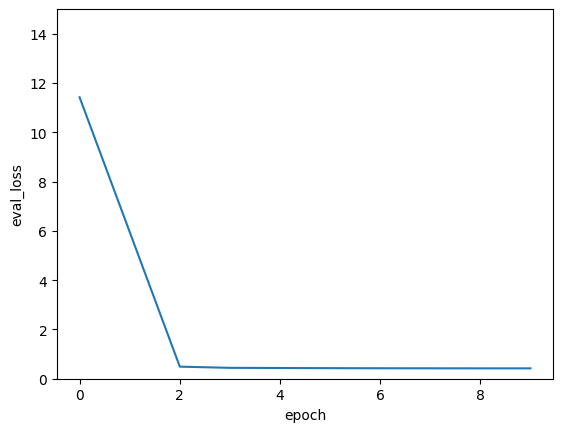

In [10]:
plt.ylim(0,15)
# plt.axhline(y=20.85, color='r', linestyle='--')
sns.lineplot(data=df, x='epoch', y='eval_loss')

The loss function shows a steep decline after the first two epochs, meaning that even after just the first 40 hours of training there does not seem to be a significant increase in performance.

Now let's look at the bleu metric. For reference, we include the bleu performance of the ReProver model on its validation set, 0.038, as a red dotted line.

<Axes: xlabel='epoch', ylabel='eval_bleu_bleu'>

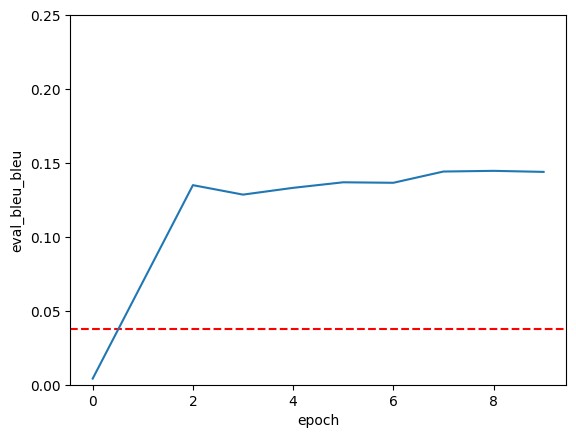

In [11]:
plt.ylim(0,.25)
plt.axhline(y=0.038, color='r', linestyle='--')
sns.lineplot(data=df, x='epoch', y='eval_bleu_bleu')

We again see that after 2 epochs, the model has reached a plateau. We also see that the models score significantly higher than ReProver's score, which does not necessarily mean our model is "better," but does provide some confidence that we probably shouldn't be expecting scores any higher than what we are already seeing.

We see a similar phenomenon with the chr f score, for which the ReProver scores 12.78 on its validation set.

<Axes: xlabel='epoch', ylabel='eval_chr_f_score'>

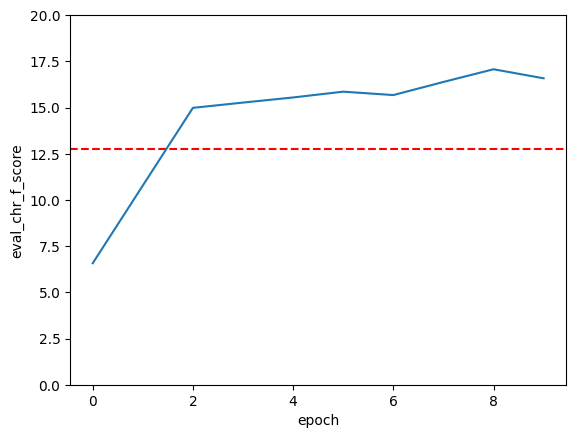

In [12]:
plt.ylim(0,20)
plt.axhline(y=12.78, color='r', linestyle='--')
sns.lineplot(data=df, x='epoch', y='eval_chr_f_score')

Let's now look at what happens to these scores over 50 epochs of training on the smaller dataset.

<Axes: xlabel='step', ylabel='eval_bleu_bleu'>

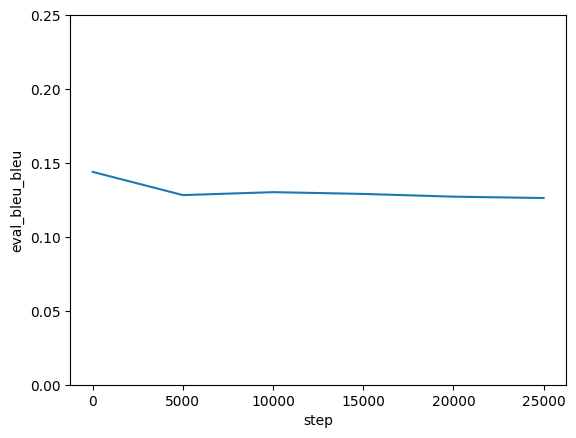

In [13]:
plt.ylim(0,.25)
sns.lineplot(data=df_short, x='step', y='eval_bleu_bleu')

<Axes: xlabel='step', ylabel='eval_chr_f_score'>

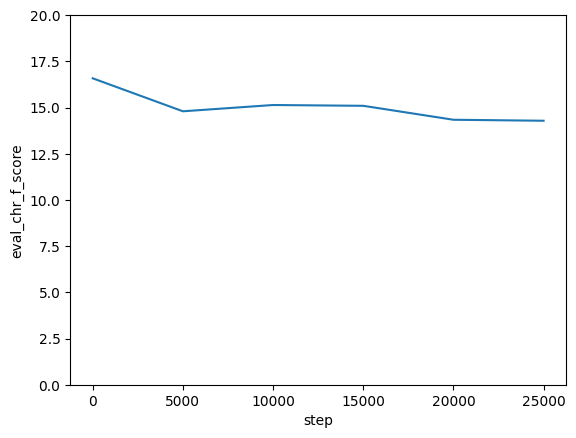

In [14]:
plt.ylim(0,20)
sns.lineplot(data=df_short, x='step', y='eval_chr_f_score')

We see a slight decline in performance, meaning that this extra training has likely only lead to overfitting.

## Conclusion

Our analysis of the bleu and chr f-scores for our models on the validation set show that epoch 8 or 9 is likely the best. Experimenting with the model after 9 epochs shows that it gives a useable output for at least half of the tested theorems. Given the incredibly precise nature of formal mathematics and computer code, this performance is actually solid, since a single errant character can cause the output not to compile.